In [1]:
%pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:

# Set random seed for reproducibility
np.random.seed(42)


In [2]:

# 1. Load Datasets
fraud_data = pd.read_csv('../data/Fraud_Data.csv')
ip_to_country = pd.read_csv('../data/IpAddress_to_Country.csv')
creditcard_data = pd.read_csv('../data/creditcard.csv')


# --- Task 1.1: Handle Missing Values ---

In [3]:


# Check for missing values in Fraud_Data.csv
print("Missing values in Fraud_Data.csv:")
print(fraud_data.isnull().sum())


Missing values in Fraud_Data.csv:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64


In [4]:

# Impute missing numerical values with median (e.g., purchase_value, age)
fraud_data['purchase_value'] = fraud_data['purchase_value'].fillna(fraud_data['purchase_value'].median())
fraud_data['age'] = fraud_data['age'].fillna(fraud_data['age'].median())


In [5]:

# Drop rows with missing categorical values (e.g., source, browser, sex) if any
fraud_data = fraud_data.dropna(subset=['source', 'browser', 'sex'])


In [6]:

# Check for missing values in creditcard.csv
print("\nMissing values in creditcard.csv:")
print(creditcard_data.isnull().sum())



Missing values in creditcard.csv:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [7]:

# Since creditcard.csv typically has no missing values (anonymized PCA features), no imputation needed
# If missing values exist, impute numerical features with median
creditcard_data = creditcard_data.fillna(creditcard_data.median(numeric_only=True))


# --- Task 1.2: Data Cleaning ---

In [8]:


# Remove duplicates in Fraud_Data.csv
fraud_data = fraud_data.drop_duplicates()


In [9]:

# Remove duplicates in creditcard.csv
creditcard_data = creditcard_data.drop_duplicates()


In [10]:

# Correct data types in Fraud_Data.csv
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])
fraud_data['user_id'] = fraud_data['user_id'].astype(str)
fraud_data['device_id'] = fraud_data['device_id'].astype(str)
fraud_data['ip_address'] = fraud_data['ip_address'].astype(float)


In [11]:

# Correct data types in creditcard.csv
creditcard_data['Time'] = creditcard_data['Time'].astype(float)
creditcard_data['Amount'] = creditcard_data['Amount'].astype(float)
creditcard_data['Class'] = creditcard_data['Class'].astype(int)


# --- Task 1.3: Exploratory Data Analysis (EDA) ---


Univariate Analysis for Fraud_Data.csv:
                         signup_time                  purchase_time  \
count                         151112                         151112   
mean   2015-04-20 00:56:09.511329280  2015-06-16 02:56:38.759952896   
min              2015-01-01 00:00:42            2015-01-01 00:00:44   
25%       2015-02-18 09:52:48.500000     2015-04-18 14:41:25.500000   
50%              2015-04-19 04:41:30     2015-06-18 13:46:17.500000   
75%    2015-06-18 14:47:22.750000128     2015-08-17 18:48:31.500000   
max              2015-08-18 04:40:29            2015-12-16 02:56:05   
std                              NaN                            NaN   

       purchase_value            age    ip_address          class  
count   151112.000000  151112.000000  1.511120e+05  151112.000000  
mean        36.935372      33.140704  2.152145e+09       0.093646  
min          9.000000      18.000000  5.209350e+04       0.000000  
25%         22.000000      27.000000  1.085934e

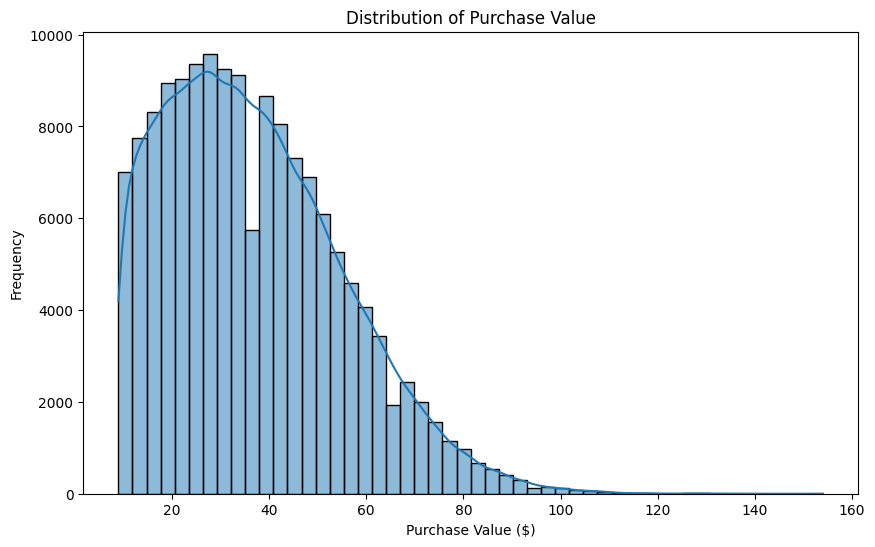

In [12]:


# Univariate Analysis for Fraud_Data.csv
print("\nUnivariate Analysis for Fraud_Data.csv:")
print(fraud_data.describe())
# Plot distribution of purchase_value
plt.figure(figsize=(10, 6))
sns.histplot(fraud_data['purchase_value'], bins=50, kde=True)
plt.title('Distribution of Purchase Value')
plt.xlabel('Purchase Value ($)')
plt.ylabel('Frequency')
plt.show()


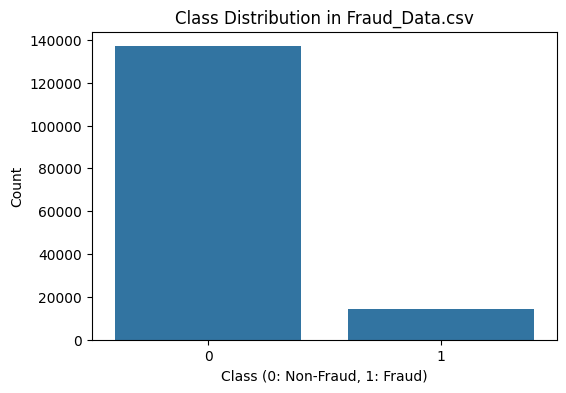

In [13]:

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=fraud_data)
plt.title('Class Distribution in Fraud_Data.csv')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()



Univariate Analysis for creditcard.csv:
                Time         Amount
count  283726.000000  283726.000000
mean    94811.077600      88.472687
std     47481.047891     250.399437
min         0.000000       0.000000
25%     54204.750000       5.600000
50%     84692.500000      22.000000
75%    139298.000000      77.510000
max    172792.000000   25691.160000


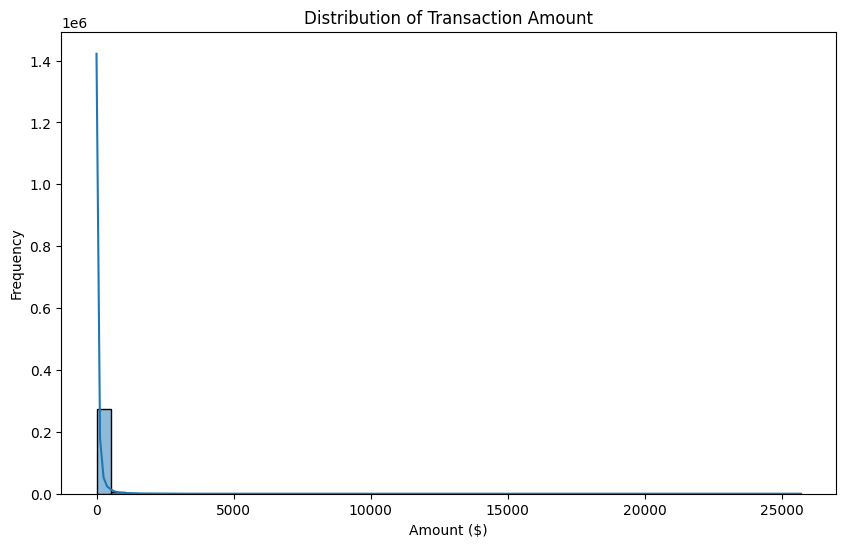

In [14]:

# Univariate Analysis for creditcard.csv
print("\nUnivariate Analysis for creditcard.csv:")
print(creditcard_data[['Time', 'Amount']].describe())
# Plot distribution of Amount
plt.figure(figsize=(10, 6))
sns.histplot(creditcard_data['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('Amount ($)')
plt.ylabel('Frequency')
plt.show()


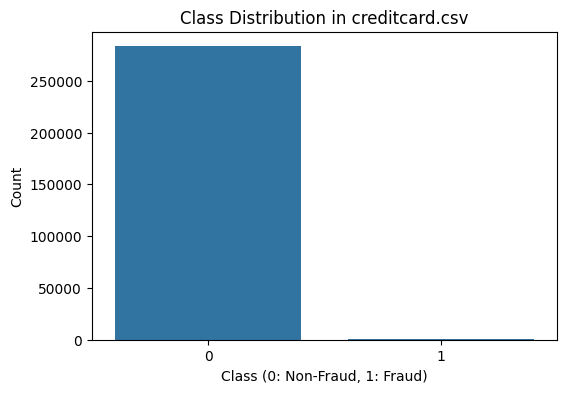

In [15]:

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=creditcard_data)
plt.title('Class Distribution in creditcard.csv')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()


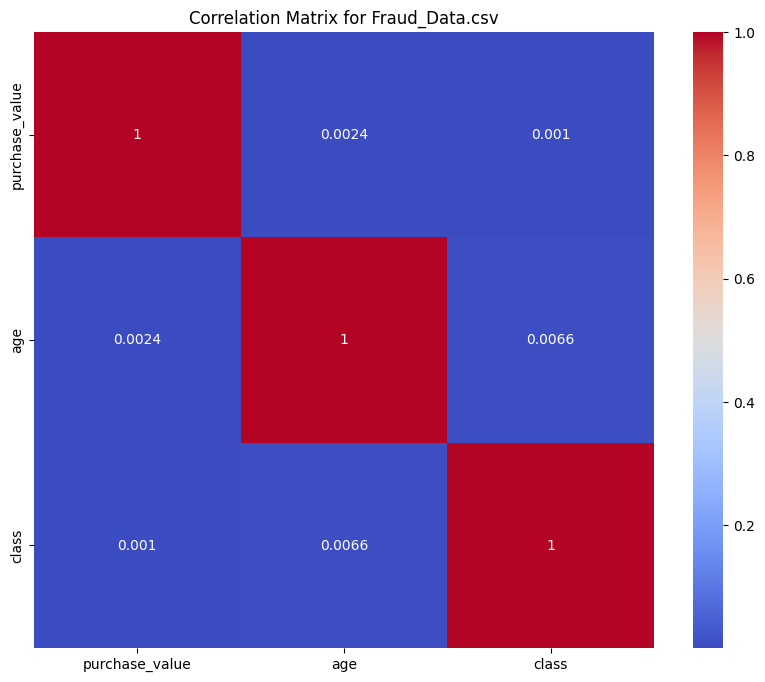

In [16]:

# Bivariate Analysis for Fraud_Data.csv
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(fraud_data[['purchase_value', 'age', 'class']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Fraud_Data.csv')
plt.show()


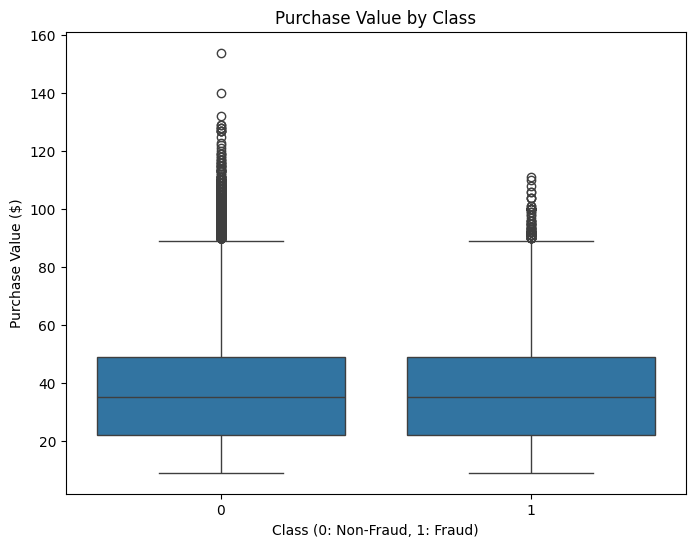

In [17]:

# Boxplot of purchase_value by class
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.title('Purchase Value by Class')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Purchase Value ($)')
plt.show()


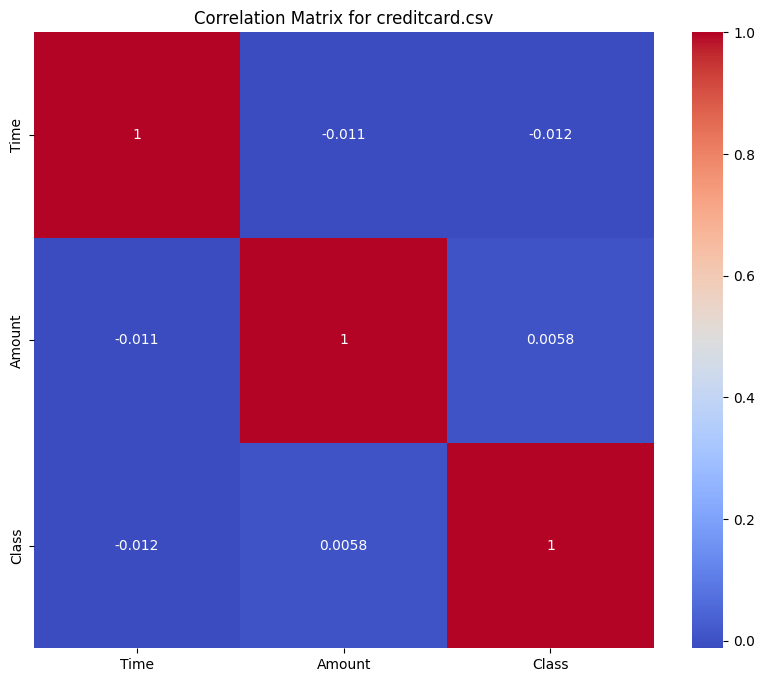

In [18]:

# Bivariate Analysis for creditcard.csv
# Correlation matrix for selected features
plt.figure(figsize=(10, 8))
sns.heatmap(creditcard_data[['Time', 'Amount', 'Class']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for creditcard.csv')
plt.show()


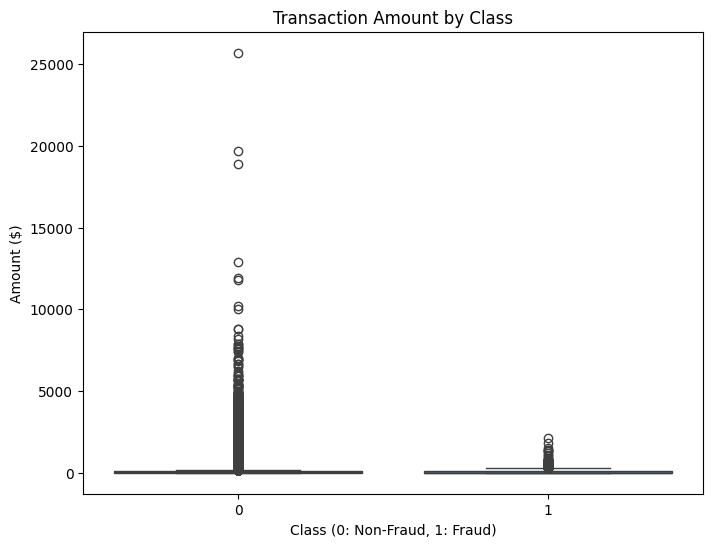

In [19]:

# Boxplot of Amount by Class
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=creditcard_data)
plt.title('Transaction Amount by Class')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Amount ($)')
plt.show()


# --- Task 1.4: Merge Datasets for Geolocation Analysis ---

In [20]:


# Convert IP addresses to integer format
fraud_data['ip_address_int'] = fraud_data['ip_address'].astype(int)
ip_to_country['lower_bound_ip_address'] = ip_to_country['lower_bound_ip_address'].astype(int)
ip_to_country['upper_bound_ip_address'] = ip_to_country['upper_bound_ip_address'].astype(int)


In [21]:
# Sort both dataframes by IP address
fraud_data_sorted = fraud_data.sort_values('ip_address_int')
ip_to_country_sorted = ip_to_country.sort_values('lower_bound_ip_address')

# Use merge_asof to match IP addresses to country ranges
fraud_data_sorted = pd.merge_asof(
    fraud_data_sorted,
    ip_to_country_sorted,
    left_on='ip_address_int',
    right_on='lower_bound_ip_address',
    direction='backward'
)

# Filter out rows where ip_address_int > upper_bound_ip_address
fraud_data_sorted['country'] = np.where(
    fraud_data_sorted['ip_address_int'] <= fraud_data_sorted['upper_bound_ip_address'],
    fraud_data_sorted['country'],
    'Unknown'
)

# Update fraud_data with country info
fraud_data['country'] = fraud_data_sorted['country'].values


# --- Task 1.5: Feature Engineering for Fraud_Data.csv ---

In [22]:


# Transaction frequency (number of transactions per user)
transaction_frequency = fraud_data.groupby('user_id').size().reset_index(name='transaction_frequency')
fraud_data = fraud_data.merge(transaction_frequency, on='user_id', how='left')


In [23]:

# Transaction velocity (average time between transactions for each user)
fraud_data = fraud_data.sort_values(['user_id', 'purchase_time'])
fraud_data['time_diff'] = fraud_data.groupby('user_id')['purchase_time'].diff().dt.total_seconds()
fraud_data['transaction_velocity'] = fraud_data.groupby('user_id')['time_diff'].transform('mean')


In [24]:

# Time-based features
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600  # in hours


# --- Task 6: Data Transformation ---

In [25]:


# Handle Class Imbalance for Fraud_Data.csv
# Analyze class distribution
print("\nClass distribution in Fraud_Data.csv:")
print(fraud_data['class'].value_counts(normalize=True))



Class distribution in Fraud_Data.csv:
class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


In [26]:

# Apply SMOTE to training data only (split data first)
from sklearn.model_selection import train_test_split


In [30]:
# Define features and target
features = ['purchase_value', 'age', 'transaction_frequency', 'transaction_velocity', 'hour_of_day', 'day_of_week', 'time_since_signup']
categorical_cols = ['source', 'browser', 'sex', 'country']

In [31]:

# Split data
X = fraud_data[features + categorical_cols]
y = fraud_data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [34]:
# Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])


In [35]:

# Combine numerical and encoded categorical features
X_train_num = X_train[features].values
X_test_num = X_test[features].values
X_train_full = np.hstack([X_train_num, X_train_cat])
X_test_full = np.hstack([X_test_num, X_test_cat])


In [37]:

from sklearn.impute import SimpleImputer

# Impute missing values in numerical features
num_imputer = SimpleImputer(strategy='median')
X_train_num_imputed = num_imputer.fit_transform(X_train_num)

# Impute missing values in categorical features (if any)
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat_imputed = cat_imputer.fit_transform(X_train_cat)

# Combine imputed numerical and categorical features
X_train_full_imputed = np.hstack([X_train_num_imputed, X_train_cat_imputed])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_full_imputed, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True))


C:\Users\belet\AppData\Roaming\Python\Python313\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: [3]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



Class distribution after SMOTE:
class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [39]:

# Impute missing values in test set
X_test_num_imputed = num_imputer.transform(X_test_num)
X_test_cat_imputed = cat_imputer.transform(X_test_cat)
X_test_full_imputed = np.hstack([X_test_num_imputed, X_test_cat_imputed])

# Normalization and Scaling
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test_full_imputed)


C:\Users\belet\AppData\Roaming\Python\Python313\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: [3]. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [40]:

# Save preprocessed datasets
np.save('../data/processed/Fraud_Data_X_train_smote_scaled.npy', X_train_smote_scaled)
np.save('../data/processed/Fraud_Data_y_train_smote.npy', y_train_smote)
np.save('../data/processed/Fraud_Data_X_test_scaled.npy', X_test_scaled)
np.save('../data/processed/Fraud_Data_y_test.npy', y_test)


In [41]:

# Scaling for creditcard.csv
scaler_credit = StandardScaler()
X_credit = creditcard_data.drop(columns=['Class'])
y_credit = creditcard_data['Class']
X_credit_scaled = scaler_credit.fit_transform(X_credit)

np.save('../data/processed/creditcard_X_scaled.npy', X_credit_scaled)
np.save('../data/processed/creditcard_y.npy', y_credit)

print("\nPreprocessing complete. Preprocessed arrays saved as .npy files.")


Preprocessing complete. Preprocessed arrays saved as .npy files.


In [42]:
%pip list

Package                                  Version
---------------------------------------- ------------
aiohappyeyeballs                         2.6.1
aiohttp                                  3.12.13
aiohttp-retry                            2.9.1
aiosignal                                1.3.2
amqp                                     5.3.1
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.9.0
appdirs                                  1.4.4
asttokens                                3.0.0
asyncssh                                 2.21.0
atpublic                                 6.0.1
attrs                                    25.3.0
backoff                                  2.2.1
bcrypt                                   4.3.0
billiard                                 4.2.1
blis                                     1.3.0
build                                    1.2.2.post1
cachetools                               